In [58]:
from utils import *
from sklearn.datasets import make_friedman1
from scipy import optimize
from scipy.stats import spearmanr
corrcoef_type = 'p'
c_val_bounds = 'fixed' #(1e-9, 1e5) 

# Friedman 1 Data

## Dataset

In [59]:
# add noise
# redo with scipy.minimize
X, y = make_friedman1(random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noiseless

### $\mathbb{R}^d$

In [60]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=c_val_bounds
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  0.441**2 * NTK(depth=3, c=2.000, bias=0.353)
NTK     :  0.0718**2 * NTK(depth=100, c=2.000, bias=0.193)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [4]:
#np.corrcoef((y-mean_ntk_1)[:,0],
#     (y-mean_lpk)[:,0]
#     )
spearmanr((y-mean_ntk_1), (y-mean_lpk))[0]

0.8369756975697569

In [5]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [6]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [7]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [66]:
def g(ell, gp, residual, p_or_s = 'p'):
    gp.set_params(**{'kernel__k2__length_scale': ell})
    gp.fit(X_train, y_train)
    mean = gp.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [67]:
ell_3 = optimize.minimize_scalar(g, args=(gp_lpk, y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':2})
ell_3


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.8827383662218652
 message: 'Solution found.'
    nfev: 26
     nit: 26
  status: 0
 success: True
       x: 1441197.1182902863

In [65]:
ell_3.fun, ell_3.x

(-0.8827383662218652, 1441197.1182902863)

In [10]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06    -0.796907        initial
    2    6.18034e+06    -0.802861        golden
    3    7.63932e+06    -0.805574        golden
    4    8.54102e+06    -0.806964        golden
    5     9.0983e+06    -0.807728        golden
    6    9.44272e+06    -0.808168        golden
    7    9.65558e+06    -0.808427        golden
    8    9.78714e+06    -0.808583        golden
    9    9.86844e+06    -0.808678        golden
   10    9.91869e+06    -0.808736        golden
   11    9.94975e+06    -0.808772        golden
   12    9.96894e+06    -0.808794        golden
   13    9.98081e+06    -0.808807        golden
   14    9.98814e+06    -0.808816        golden
   15    9.99267e+06    -0.808821        golden
   16    9.99547e+06    -0.808824        golden
   17     9.9972e+06    -0.808826        golden
   18    9.99827e+06    -0.808827        golden
   19    9.99893e+06    -0.808828        golden
   20    9.99934e+06    -0.808828 

     fun: -0.8088291633380169
 message: 'Solution found.'
    nfev: 36
     nit: 36
  status: 0
 success: True
       x: 9999998.228909653

In [11]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

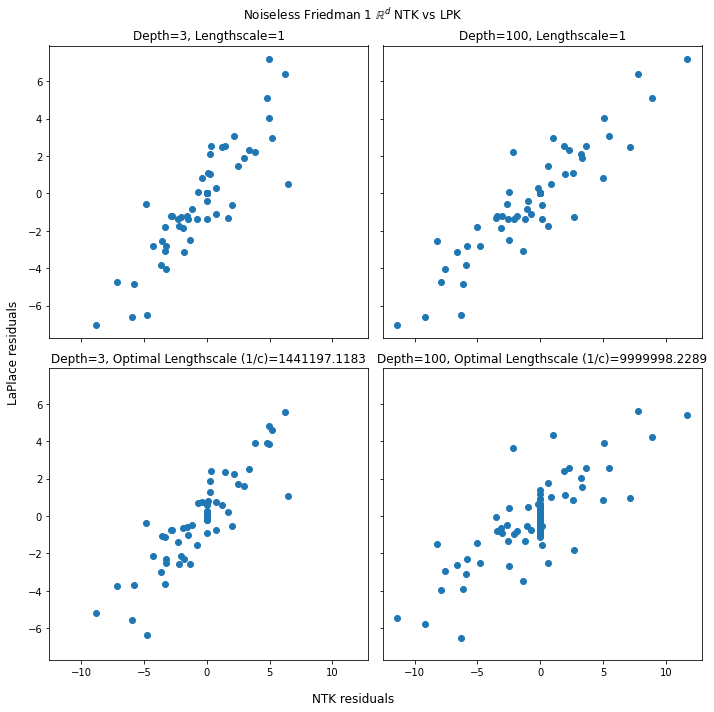

In [12]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noiseless Friedman 1 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

Data Table - $\mathbb{R}^{d}$
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 1441197.1 |            |
| Pearson - $f(x)$ | 0.8827    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 9999998.2 |            |
| Pearson - $f(x)$ | 0.8088    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

### $\mathbb{S}^{d-1}$

In [13]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=c_val_bounds
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

NTK     :  0.725**2 * NTK(depth=3, c=2.000, bias=0.417)
NTK     :  0.114**2 * NTK(depth=100, c=2.000, bias=0.000)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [14]:
# nn = MLPR(
#     hidden_layer_sizes=(20000, 3),
#     solver='sgd',
#     max_iter=10000,
#     alpha=0,
#     learning_rate='constant',
#     learning_rate_init=0.00099,
#     momentum = 0.95,
#     nesterovs_momentum=True,
#     tol=0.000001,
#     n_iter_no_change = 20,
#     random_state = 123457908,
#     shuffle=True,
#     verbose=True)
# nn.fit(X_train_norm, y_train_norm.ravel())
# mean_nn = nn.predict(X_norm).reshape(-1,1)

In [15]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [16]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [17]:
def g(ell, residual, p_or_s = 'p'):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [18]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.860593        initial
    2        61.8038    -0.859964        golden
    3        23.6076    -0.861595        golden
    4        14.5907    -0.863179        golden
    5         9.0179    -0.865637        golden
    6        5.57375    -0.869336        golden
    7        3.44515    -0.874582        golden
    8         2.1296    -0.881119        golden
    9        1.31655     -0.88682        golden
   10       0.814054    -0.885419        golden
   11        1.25242    -0.887162        parabolic
   12        1.14061    -0.887572        parabolic
   13        1.01588    -0.887567        golden
   14        1.07952    -0.887649        parabolic
   15        1.07923    -0.887649        parabolic
   16        1.07576    -0.887649        parabolic
   17        1.05289    -0.887637        golden
   18        1.07611    -0.887649        parabolic
   19        1.07612    -0.887649        parabolic
   20        

     fun: -0.8876488423652513
 message: 'Solution found.'
    nfev: 21
     nit: 21
  status: 0
 success: True
       x: 1.0761219116473002

In [19]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.779061        initial
    2        61.8038    -0.777439        golden
    3        23.6076    -0.781681        golden
    4        14.5907     -0.78591        golden
    5         9.0179    -0.792715        golden
    6        5.57375    -0.803591        golden
    7        3.44515    -0.820722        golden
    8         2.1296    -0.846849        golden
    9        1.31655    -0.884052        golden
   10       0.814054    -0.930093        golden
   11       0.503495    -0.973227        golden
   12       0.311559    -0.995971        golden
   13       0.192936    -0.998416        golden
   14        0.21955    -0.998704        parabolic
   15       0.222071    -0.998713        parabolic
   16       0.228157    -0.998719        parabolic
   17       0.260014     -0.99833        golden
   18       0.226814     -0.99872        parabolic
   19        0.22676     -0.99872        parabolic
   20       0.22677

     fun: -0.9987196324553811
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 0.2267738683140398

In [20]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

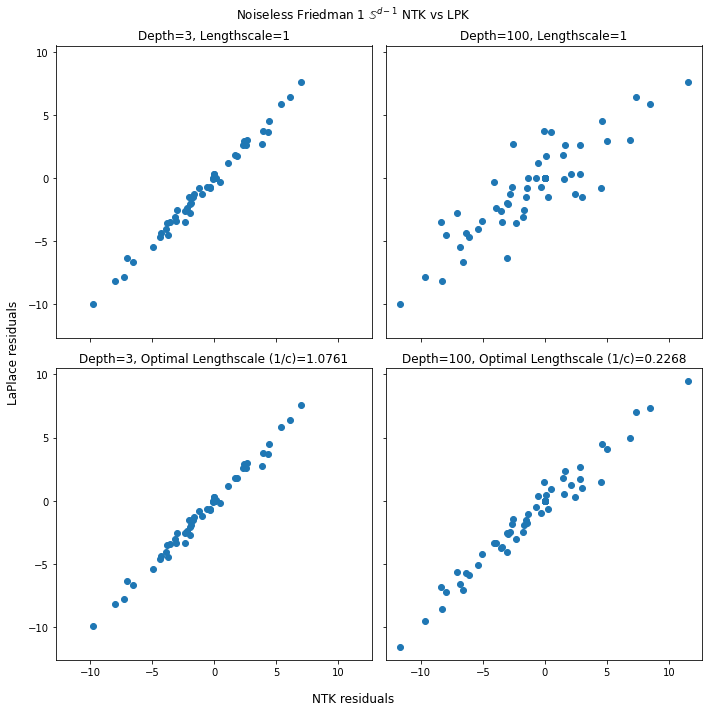

In [21]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 1 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

Data Table - $\mathbb{S}^{d-1}$ LPK
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 1.0761219 |            |
| Pearson - $f(x)$ | 0.8876    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 0.2267738 |            |
| Pearson - $f(x)$ | 0.9987    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

### RBF

In [22]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=c_val_bounds
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)



In [23]:
def h(ell, residual, p_or_s = 'p'):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train, y_train)
    mean = gp_rbf.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [24]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06    -0.565982        initial
    2    6.18034e+06     -0.56598        golden
    3    2.36068e+06    -0.565986        golden
    4    1.45898e+06    -0.565999        golden
    5         901699     -0.56603        golden
    6         557281    -0.566114        golden
    7         344419    -0.566332        golden
    8         212862    -0.566901        golden
    9         131556    -0.568374        golden
   10        81306.2    -0.572129        golden
   11          50250    -0.581313        golden
   12        31056.2    -0.601628        golden
   13        19193.8    -0.637108        golden
   14        11862.4    -0.671375        golden
   15        7331.38    -0.667589        golden
   16        10496.4    -0.674898        parabolic
   17        9984.12    -0.675429        parabolic
   18        9609.92     -0.67547        parabolic
   19        9744.13    -0.675491        parabolic
   20        9747.76  

     fun: -0.6754912935745343
 message: 'Solution found.'
    nfev: 45
     nit: 45
  status: 0
 success: True
       x: 9747.0671173726

In [25]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06     -0.72366        initial
    2    6.18034e+06    -0.723659        golden
    3    2.36068e+06    -0.723663        golden
    4    1.45898e+06    -0.723669        golden
    5         901699    -0.723686        golden
    6         557281     -0.72373        golden
    7         344419    -0.723845        golden
    8         212862    -0.724143        golden
    9         131556     -0.72491        golden
   10        81306.2    -0.726814        golden
   11          50250    -0.731161        golden
   12        31056.2    -0.739061        golden
   13        19193.8     -0.74508        golden
   14        11862.4    -0.723961        golden
   15        23724.8    -0.743702        golden
   16        15977.3    -0.742281        parabolic
   17        20456.2    -0.745049        parabolic
   18        19682.9    -0.745117        parabolic
   19        19731.2    -0.745117        parabolic
   20        19709.8  

     fun: -0.745117172683013
 message: 'Solution found.'
    nfev: 31
     nit: 31
  status: 0
 success: True
       x: 19709.814077837993

In [26]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

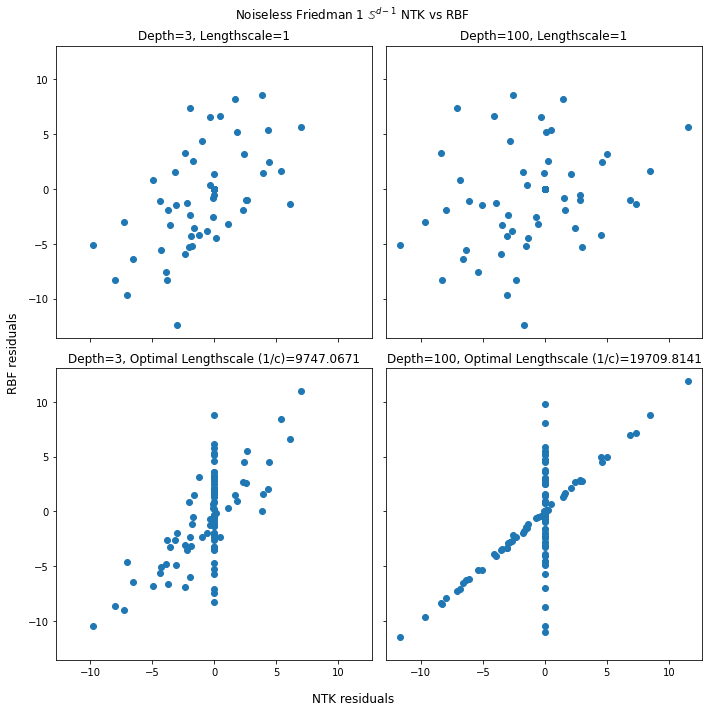

In [27]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 1 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

Data Table - $\mathbb{S}^{d-1}$ - RBF
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 9747.0671 |            |
| Pearson - $f(x)$ | 0.6754    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 19709.814 |            |
| Pearson - $f(x)$ | 0.7451    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

In [28]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [29]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

## Dataset

In [30]:
X, y = make_friedman1(noise=0.2, random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noisy

### $\mathbb{R}^d$

In [31]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=c_val_bounds
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

NTK     :  0.442**2 * NTK(depth=3, c=2.000, bias=0.354)


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  0.0718**2 * NTK(depth=100, c=2.000, bias=0.193)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [32]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [33]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [34]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [35]:
def g(ell, residual, p_or_s = 'p'):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [36]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06    -0.877629        initial
    2    6.18034e+06     -0.87403        golden
    3    2.36068e+06    -0.878839        golden
    4         815131    -0.878889        parabolic
    5    1.52661e+06    -0.879049        parabolic
    6     1.5353e+06    -0.879049        parabolic
    7    1.51579e+06    -0.879049        parabolic
    8    1.51484e+06    -0.879049        parabolic
    9    1.51579e+06    -0.879049        parabolic
   10    1.51531e+06    -0.879049        parabolic
   11     1.5156e+06    -0.879049        golden
   12    1.51572e+06    -0.879049        golden
   13    1.51576e+06    -0.879049        golden
   14    1.51578e+06    -0.879049        golden
   15    1.51578e+06    -0.879049        golden
   16    1.51578e+06    -0.879049        golden
   17    1.51579e+06    -0.879049        golden
   18    1.51579e+06    -0.879049        golden
   19    1.51579e+06    -0.879049        golden
   20    1.51

     fun: -0.8790490054309269
 message: 'Solution found.'
    nfev: 24
     nit: 24
  status: 0
 success: True
       x: 1515785.8175147185

In [37]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06    -0.778219        initial
    2    6.18034e+06    -0.785038        golden
    3    7.63932e+06    -0.788211        golden
    4    8.54102e+06    -0.789861        golden
    5     9.0983e+06    -0.790778        golden
    6    9.44272e+06     -0.79131        golden
    7    9.65558e+06    -0.791625        golden
    8    9.78714e+06    -0.791815        golden
    9    9.86844e+06    -0.791931        golden
   10    9.91869e+06    -0.792002        golden
   11    9.94975e+06    -0.792045        golden
   12    9.96894e+06    -0.792072        golden
   13    9.98081e+06    -0.792089        golden
   14    9.98814e+06    -0.792099        golden
   15    9.99267e+06    -0.792105        golden
   16    9.99547e+06    -0.792109        golden
   17     9.9972e+06    -0.792111        golden
   18    9.99827e+06    -0.792113        golden
   19    9.99893e+06    -0.792114        golden
   20    9.99934e+06    -0.792114 

     fun: -0.7921152033929455
 message: 'Solution found.'
    nfev: 35
     nit: 35
  status: 0
 success: True
       x: 9999996.678126026

In [38]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

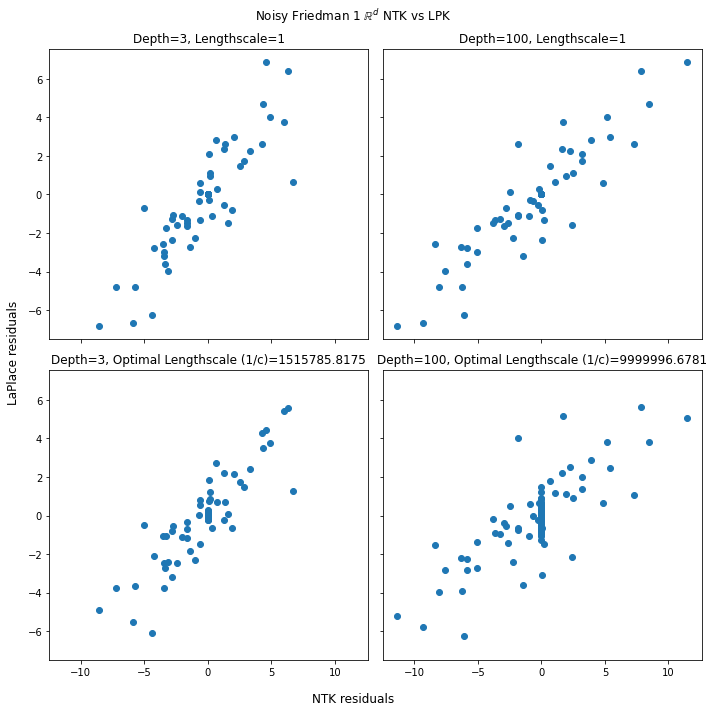

In [39]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noisy Friedman 1 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

Data Table - $\mathbb{R}^{d}$
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 1515785.8 |            |
| Pearson - $f(x)$ | 0.8790    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 9999996.6 |            |
| Pearson - $f(x)$ | 0.7921    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

### $\mathbb{S}^{d-1}$

In [40]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=c_val_bounds
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  0.703**2 * NTK(depth=3, c=2.000, bias=0.526)
NTK     :  0.114**2 * NTK(depth=100, c=2.000, bias=0.000)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [41]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [42]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [43]:
def g(ell, residual, p_or_s = 'p'):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [44]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.853944        initial
    2        61.8038    -0.853248        golden
    3        23.6076    -0.855055        golden
    4        14.5907    -0.856811        golden
    5         9.0179    -0.859545        golden
    6        5.57375    -0.863676        golden
    7        3.44515     -0.86957        golden
    8         2.1296    -0.876991        golden
    9        1.31655    -0.883627        golden
   10       0.814054    -0.882529        golden
   11        1.20425    -0.884314        parabolic
   12        1.11664    -0.884652        parabolic
   13        1.00106    -0.884644        golden
   14        1.06054    -0.884728        parabolic
   15        1.06021    -0.884728        parabolic
   16        1.05721    -0.884728        parabolic
   17        1.03576    -0.884717        golden
   18         1.0575    -0.884728        parabolic
   19         1.0575    -0.884728        parabolic
   20        

     fun: -0.8847284789046778
 message: 'Solution found.'
    nfev: 20
     nit: 20
  status: 0
 success: True
       x: 1.0575026214046306

In [45]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.757824        initial
    2        61.8038    -0.756058        golden
    3        23.6076     -0.76068        golden
    4        14.5907    -0.765293        golden
    5         9.0179    -0.772724        golden
    6        5.57375    -0.784626        golden
    7        3.44515    -0.803421        golden
    8         2.1296    -0.832175        golden
    9        1.31655    -0.873222        golden
   10       0.814054    -0.923994        golden
   11       0.503495    -0.971225        golden
   12       0.311559    -0.995765        golden
   13       0.192936    -0.998349        golden
   14       0.220353    -0.998661        parabolic
   15       0.222272    -0.998668        parabolic
   16        0.22838    -0.998675        parabolic
   17       0.260152    -0.998265        golden
   18       0.227076    -0.998675        parabolic
   19       0.227024    -0.998675        parabolic
   20       0.22703

     fun: -0.9986754098428052
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 0.22703789218938678

In [46]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

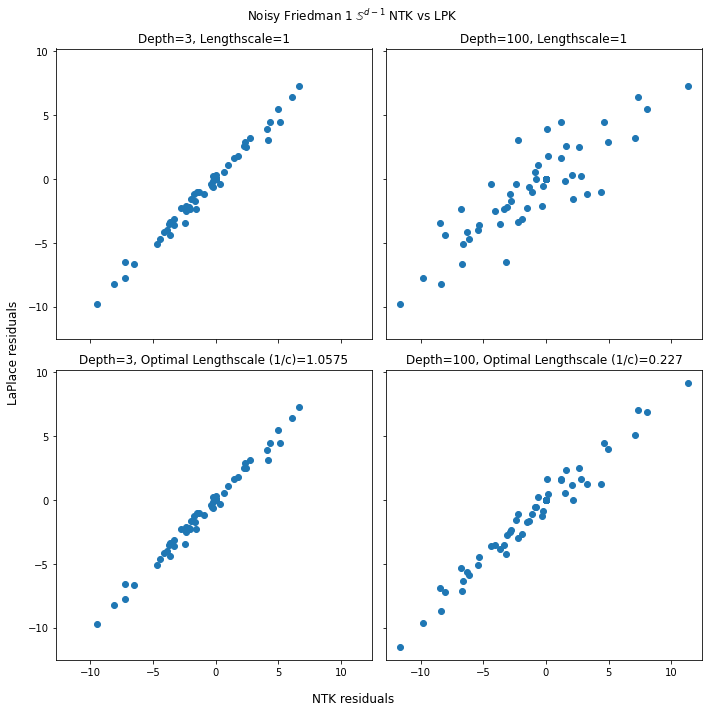

In [47]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 1 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

Data Table - $\mathbb{S}^{d-1}$ LPK
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 1.0761219 |            |
| Pearson - $f(x)$ | 0.8876    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 0.2267738 |            |
| Pearson - $f(x)$ | 0.9987    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

### RBF

In [48]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=c_val_bounds
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)

In [49]:
def h(ell, residual, p_or_s = 'p'):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train, y_train)
    mean = gp_rbf.predict(X)
    if p_or_s == 's':
        return -spearmanr(residual, y-mean)[0]
    else:
        return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [50]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06     -0.55336        initial
    2    6.18034e+06    -0.553342        golden
    3    2.36068e+06    -0.553408        golden
    4    1.45898e+06    -0.553534        golden
    5         901699    -0.553862        golden
    6         557281    -0.554716        golden
    7         344419    -0.556918        golden
    8         212862    -0.562469        golden
    9         131556    -0.575661        golden
   10        81306.2    -0.602931        golden
   11          50250    -0.643365        golden
   12        31056.2    -0.667029        golden
   13        19193.8    -0.647463        golden
   14          34011    -0.665914        parabolic
   15          31154    -0.667021        parabolic
   16        30717.4    -0.667039        parabolic
   17        30756.5     -0.66704        parabolic
   18        30754.5     -0.66704        parabolic
   19        30739.5     -0.66704        parabolic
   20        307

     fun: -0.6670396596972366
 message: 'Solution found.'
    nfev: 35
     nit: 35
  status: 0
 success: True
       x: 30751.739966896876

In [51]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2, corrcoef_type), method='bounded', bounds=[0.001, 10000000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1    3.81966e+06    -0.716362        initial
    2    6.18034e+06    -0.716352        golden
    3    2.36068e+06    -0.716386        golden
    4    1.45898e+06     -0.71645        golden
    5         901699    -0.716616        golden
    6         557281    -0.717046        golden
    7         344419    -0.718138        golden
    8         212862     -0.72078        golden
    9         131556    -0.726403        golden
   10        81306.2    -0.734612        golden
   11          50250    -0.732716        golden
   12        76837.9    -0.735396        parabolic
   13        69209.2    -0.736424        parabolic
   14        61967.4    -0.736604        golden
   15        63898.4    -0.736672        parabolic
   16        64483.8    -0.736673        parabolic
   17          64266    -0.736674        parabolic
   18        64275.4    -0.736674        parabolic
   19          64331    -0.736674        parabolic
   20        

     fun: -0.7366738685544317
 message: 'Solution found.'
    nfev: 36
     nit: 36
  status: 0
 success: True
       x: 64306.58212975864

In [52]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

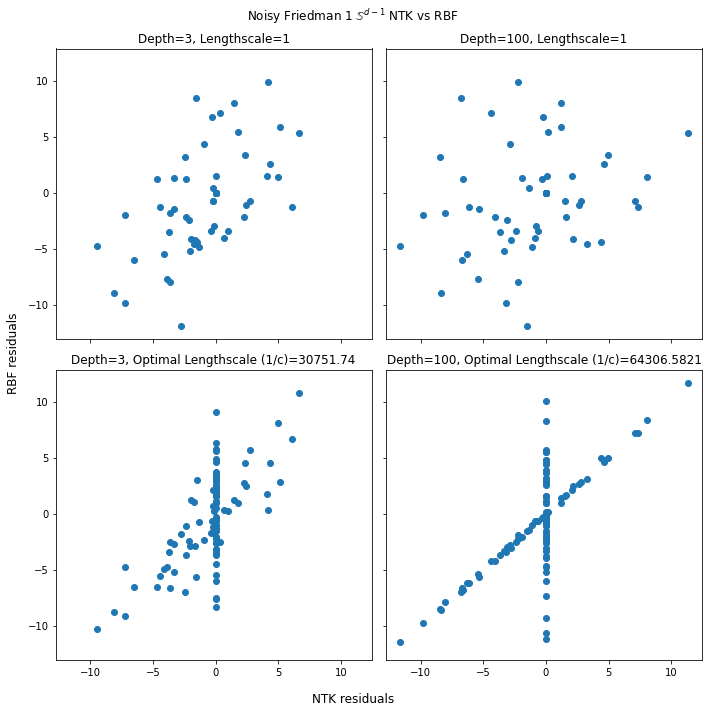

In [53]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 1 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

Data Table - $\mathbb{S}^{d-1}$ - RBF
| NTK Depth=3      | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 9747.0671 |            |
| Pearson - $f(x)$ | 0.6754    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

| NTK Depth=100    | Fixed     | Unfixed    |
|------------------|-----------|------------|
| Pearson - $x$    | 19709.814 |            |
| Pearson - $f(x)$ | 0.7451    |            |
| Spearman - $x$   |           |            |
| Spearman - $f(x)$|           |            |

In [54]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [55]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

In [56]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_rbf)[:,0])

array([[1.        , 0.57826697],
       [0.57826697, 1.        ]])

In [57]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_lpk)[:,0])

array([[1.        , 0.99368528],
       [0.99368528, 1.        ]])